In [49]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from datetime import timedelta

In [50]:
energy_meters_df = pd.read_excel('data/VIS Målere.xlsx')
# Remove leading and trailing whitespace in cells with value of type string
energy_meters_df = energy_meters_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [51]:
energy_meters_df

,Objekt,Navn,Type,Formel,UoM,Målernivå
0,Bygg,Trondheim Kommune - Ranheimsfjæra barnehage,NaN,NaN,NaN,NaN
1,Bygg,Trondheim Kommune - Hesteskoen barnehage,NaN,NaN,NaN,NaN
2,VIS-Måler,Temp middel,Temperatur,Eklima_68860_TAM,°C,Annen måler
3,Bygg,Trondheim Kommune - Torvet,NaN,NaN,NaN,NaN
4,VIS-Måler,Fjernvarme 66217271,Fjernvarme,ESAVE_279829-980396002_EAN,kWh,Forbruksmåler
...,...,...,...,...,...,...
1432,Bygg,Trondheim Kommune - Angelltrøa barnehage,NaN,NaN,NaN,NaN
1433,VIS-Måler,Trondheim Voll,Temperatur,Eklima_68860_TAM,°C,Annen måler
1434,VIS-Måler,Voll TAN,Temperatur,Eklima_68860_TAN,°C,Annen måler
1435,VIS-Måler,Graddager,Graddager,Eklima_68860_GD17,grdg,Annen måler


Types of sensors and coresponding unit of measurement:  
'Ikke valgt(Ikke valgt)','Elkjel(kWh)', 'Temperatur(°C)', 'Ikke valgt(°C)', 'Fjernvarme(kWh)', 'Ikke valgt(m/s)', 'Vann(m3)', 'Ikke valgt(kWh)', 'Ikke valgt(timer)', 'Fastkraft(kWh)', 'Virkningsgrad(nan)', 'Kjøling(kWh)', 'Varme(kWh)', 'Virkningsgrad(Ikke valgt)', 'Graddager(grdg)'

In [52]:
start_time = time()

buildings = {}
current_building = None
sensor_types = ['Fastkraft', 'Fjernvarme', 'Varme', 'Elkjel', 'Kjøling']
for _, row in energy_meters_df.iterrows():
    # if current row is a building not a sensor create a new dict to store all sensors for that building
    if row['Objekt'] == 'Bygg':
        current_building = {}
        for sensor_type in sensor_types:
            current_building[sensor_type] = {}
        buildings[row['Navn']] = current_building
        continue
    
    sensor_type = row['Type']
    if sensor_type in sensor_types:
        name = row['Navn']
        sensor_id = row['Formel']
        current_building[sensor_type][name] = sensor_id


stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to parse')

Used 0.04 seconds to parse


In [53]:
start_time = time()

raw_esave_tables = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', parse_dates=['Unnamed: 0'], decimal=',', sheet_name=None)
raw_esave_table = pd.concat(raw_esave_tables)
raw_esave_table.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
raw_esave_table.set_index('datetime', inplace=True)

stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to read esave table')

Used 84.44 seconds to read esave table


In [56]:
raw_esave_table

,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN,707057500068789658,707057500068425556,707057500068402960,707057500068104048,707057500068744237,ESAVE_942110464_2_ID,707057500068750269,...,ESAVE_LeaIsh:US05_B_E_MtrH15_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH16_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH2_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH3_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH5_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH6_CumEg_EAN,ESAVE_LeaIsh:US05_B_E_MtrH7_CumEg_EAN,707057500068858477,ESAVE_280058-980396002_EAN,ESAVE_942110464_25_ID
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,9.4,7.2,8.0,7.1,4.0,6.7,9.9,14.6,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,9.6,7.2,9.0,7.0,7.0,8.6,10.0,14.6,NaN,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,8.7,7.2,9.0,6.2,6.0,10.4,8.8,15.0,NaN,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,8.8,7.2,9.0,7.8,5.0,10.2,10.2,16.6,NaN,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 04:00:00,9.1,7.2,9.0,7.0,5.0,9.8,9.9,15.4,NaN,18.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,223.0,129.0,10.0,40.0,0.0,0.0,101.0,110.0,0.59
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,220.0,129.0,11.0,50.0,0.0,0.0,100.0,130.0,0.59
2020-01-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,220.0,131.0,12.0,50.0,0.0,0.0,111.0,110.0,0.59


In [76]:
building_dfs = {}

i = 0
n = 0

for name, sensor_type_dicts in buildings.items():
    

    sensor_type_series = {}
    for sensor_type, sensor_dicts in sensor_type_dicts.items():
        for sensor_id in sensor_dicts.values():
            n += 1
            if sensor_id in raw_esave_table.columns:
                i += 1
                sensor_series = raw_esave_table[sensor_id]
                print(sensor_series)
                if not sensor_type in sensor_type_series:
                    sensor_type_series[sensor_type] = sensor_series
                else:
                    sensor_type_series[sensor_type] = sensor_type_series[sensor_type] + sensor_series
    
    building_dfs[name] = pd.DataFrame(sensor_type_series)

print(f'i: {i}  n: {n}  i/n: {i/n:.2f}')


datetime
2015-01-01 00:00:00   NaN
2015-01-01 01:00:00   NaN
2015-01-01 02:00:00   NaN
2015-01-01 03:00:00   NaN
2015-01-01 04:00:00   NaN
                       ..
2020-01-01 19:00:00   NaN
2020-01-01 20:00:00   NaN
2020-01-01 21:00:00   NaN
2020-01-01 22:00:00   NaN
2020-01-01 23:00:00   NaN
Name: 707057500068610792, Length: 306936, dtype: float64
datetime
2015-01-01 00:00:00   NaN
2015-01-01 01:00:00   NaN
2015-01-01 02:00:00   NaN
2015-01-01 03:00:00   NaN
2015-01-01 04:00:00   NaN
                       ..
2020-01-01 19:00:00   NaN
2020-01-01 20:00:00   NaN
2020-01-01 21:00:00   NaN
2020-01-01 22:00:00   NaN
2020-01-01 23:00:00   NaN
Name: ESAVE_249000-980396002_EAN, Length: 306936, dtype: float64
datetime
2015-01-01 00:00:00   NaN
2015-01-01 01:00:00   NaN
2015-01-01 02:00:00   NaN
2015-01-01 03:00:00   NaN
2015-01-01 04:00:00   NaN
                       ..
2020-01-01 19:00:00   NaN
2020-01-01 20:00:00   NaN
2020-01-01 21:00:00   NaN
2020-01-01 22:00:00   NaN
2020-01-01 23:00:00

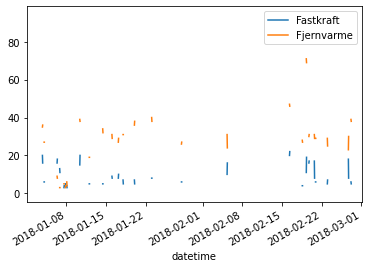

In [75]:
plot_inter = (datetime(2018,1,1,1), datetime(2018,3,1,1))

building_dfs['Trondheim Kommune - Voldsminde barnehage'].plot(xlim=plot_inter)
plt.show()
